# Student Model Testing Notebook

In [ ]:
# Setup
import sys
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Imports
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from tqdm import tqdm
import time

from src.data.data_loader import TeacherDataLoader
from src.data.preprocessor import ReasoningPreprocessor, PreprocessConfig
from src.data.dataset import ESNLIDataset, create_dataloaders

from src.models.student import (
    StudentModel,
    StudentConfig,
    create_student_model,
    compare_model_sizes
)
from src.models.teacher import (
    DatasetTeacher
)

# Styling
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Set device (GPU or CPU)
# This determines where models and tensors will be loaded
device = "cuda" if torch.cuda.is_available() else "cpu"

DEVICE CONFIGURATION

Device: CUDA
GPU: NVIDIA RTX A4500
CUDA version: 12.4
GPU Memory: 21.15 GB


## 1. Compare Model Sizes
Understand the different FLAN-T5 model sizes available.

In [ ]:
# Display student model size comparison
compare_model_sizes()

FLAN-T5 MODEL SIZES
Size       Parameters      Layers (E/D)    Hidden Size    
----------------------------------------------------------------------
small      80M             6/6             512            
base       250M            12/12           768            
large      780M            24/24           1024           
xl         3B              24/24           2048           
xxl        11B             24/24           4096           

Recommendations:
  • small/base: Fast training, good for experimentation
  • large: Balanced performance/efficiency
  • xl/xxl: Best quality, but requires significant compute


## 2. Initialize Student Model
Load and inspect FLAN-T5 student model.

In [ ]:
# Create student model configuration
# This sets up all hyperparameters for the student model
print("=" * 70)
print("INITIALIZING STUDENT MODEL")
print("=" * 70)

student_config = StudentConfig(
    # Model selection: FLAN-T5-base has 250M parameters (balance between size/performance)
    model_name="google/flan-t5-base",
    
    # Input sequence length: max tokens for premise+hypothesis (256 is enough for NLI)
    max_source_length=256,
    
    # Output sequence length: max tokens for generated explanations (128 is typical)
    max_target_length=128,
    
    # Hardware: where to load the model
    device=device,

    # Beam search width: explores 4 different generation paths simultaneously
    # 1=greedy, 4=good balance
    num_beams=4,

    # Sampling temperature: controls randomness (1.0=standard, <1=focused, >1=creative)# Initialize student model
    temperature=1.0
)

student = StudentModel(student_config)

INFO:src.models.student:Initializing student model: google/flan-t5-base
`torch_dtype` is deprecated! Use `dtype` instead!


INITIALIZING STUDENT MODEL


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
INFO:src.models.student:Model loaded successfully on cuda
INFO:src.models.student:Model parameters: 247,577,856



Student model initialized!


In [8]:
# Display model information
print("\n" + "=" * 70)
print("STUDENT MODEL INFORMATION")
print("=" * 70)

model_info = student.get_model_info()
pprint(model_info)

print("\nMemory Footprint:")
memory = student.get_memory_footprint()
for key, value in memory.items():
    print(f"  {key}: {value:.2f} MB")


STUDENT MODEL INFORMATION
{'decoder_layers': 12,
 'device': 'cuda',
 'encoder_layers': 12,
 'hidden_size': 768,
 'memory_mb': 944.4345703125,
 'model_name': 'google/flan-t5-base',
 'num_heads': 12,
 'parameters': 247577856,
 'vocab_size': 32128}

Memory Footprint:
  parameters_mb: 944.43 MB
  buffers_mb: 0.00 MB
  total_mb: 944.43 MB



MODEL ARCHITECTURE SUMMARY

Encoder:
  Layers: 12
  Hidden size: 768
  Attention heads: 12

Decoder:
  Layers: 12
  Hidden size: 768
  Attention heads: 12

Vocabulary size: 32,128
Total parameters: 247,577,856


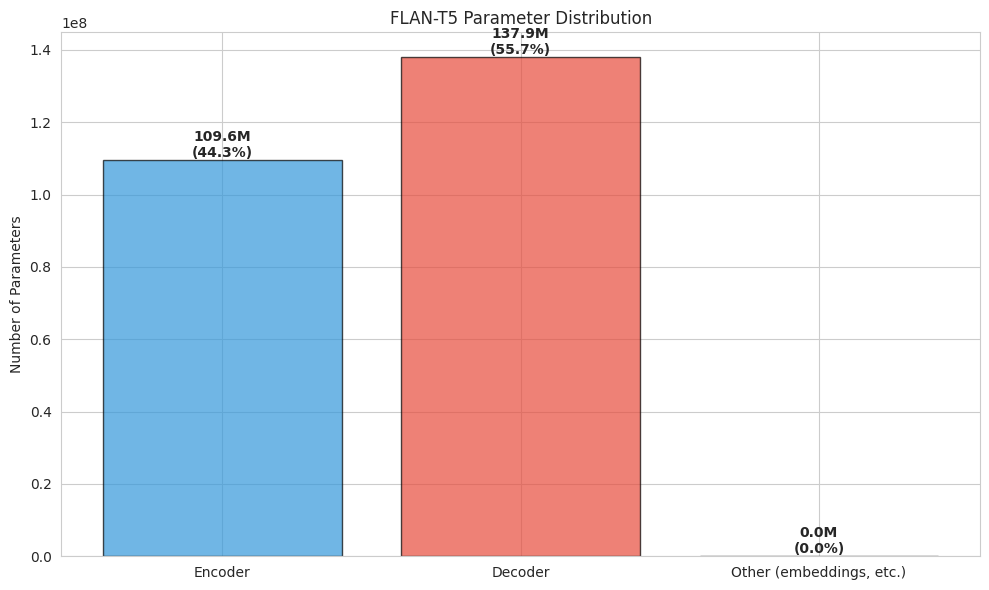

In [9]:
# Visualize model architecture
print("\n" + "=" * 70)
print("MODEL ARCHITECTURE SUMMARY")
print("=" * 70)

print(f"\nEncoder:")
print(f"  Layers: {model_info['encoder_layers']}")
print(f"  Hidden size: {model_info['hidden_size']}")
print(f"  Attention heads: {model_info['num_heads']}")

print(f"\nDecoder:")
print(f"  Layers: {model_info['decoder_layers']}")
print(f"  Hidden size: {model_info['hidden_size']}")
print(f"  Attention heads: {model_info['num_heads']}")

print(f"\nVocabulary size: {model_info['vocab_size']:,}")
print(f"Total parameters: {model_info['parameters']:,}")

# Calculate parameter distribution
encoder_params = sum(p.numel() for p in student.model.encoder.parameters())
decoder_params = sum(p.numel() for p in student.model.decoder.parameters())
other_params = model_info['parameters'] - encoder_params - decoder_params

# Plot parameter distribution
fig, ax = plt.subplots(figsize=(10, 6))
components = ['Encoder', 'Decoder', 'Other (embeddings, etc.)']
params = [encoder_params, decoder_params, other_params]
colors = ['#3498db', '#e74c3c', '#95a5a6']

bars = ax.bar(components, params, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('Number of Parameters')
ax.set_title('FLAN-T5 Parameter Distribution')

# Add value labels on bars
for bar, param in zip(bars, params):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{param/1e6:.1f}M\n({param/model_info["parameters"]*100:.1f}%)',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## 3. Load Test Data

In [ ]:
# Load small dataset for testing
print("=" * 70)
print("LOADING TEST DATA")
print("=" * 70)

loader = TeacherDataLoader()
esnli_data = loader.load_esnli()

# Use small subset
test_data = esnli_data['validation'].select(range(20))

print(f"\nLoaded {len(test_data)} test samples")

INFO:src.data.data_loader:Loading e-SNLI dataset from GitHub (OanaMariaCamburu/e-SNLI)...


LOADING TEST DATA


INFO:src.data.data_loader:Loaded e-SNLI: train=549367, val=9842, test=9824
INFO:src.data.data_loader:e-SNLI loaded successfully. Splits: ['train', 'validation', 'test']
INFO:src.data.data_loader:Sample counts: [('train', 549367), ('validation', 9842), ('test', 9824)]



Loaded 20 test samples


In [ ]:
preprocess_config = PreprocessConfig(
    model_name="google/flan-t5-base",
    max_source_length=256,
    max_target_length=128
)

# Create preprocessor
# This will handle tokenization and formatting of the data
preprocessor = ReasoningPreprocessor(preprocess_config)

# Create test dataset
test_dataset = ESNLIDataset(
    test_data,
    preprocessor,
    use_cache=False
)

# Create dataloader for testing
# This dataloader will be used to feed data to the model during evaluation
test_loader = create_dataloaders(
    test_dataset,
    batch_size=4,
    num_workers=0,
    pad_token_id=preprocessor.tokenizer.pad_token_id,
    shuffle_train=False
)

print(f"Created test dataloader with {len(test_loader)} batches")

INFO:src.data.preprocessor:Loading tokenizer: google/flan-t5-base
INFO:src.data.dataset:Initialized ESNLIDataset with 20 samples


Created test dataloader with 5 batches


## 4. Test Forward Pass (Training Mode)

In [ ]:
# Test forward pass: this represents one training step in other words, how the model computes loss during training
print("=" * 70)
print("TESTING FORWARD PASS")
print("=" * 70)

# Get a batch of 4 preprocessed samples from the dataloader
batch = next(iter(test_loader))

# Move tensors to GPU/CPU
# All tensors must be on the same device as the model for computation
batch = {k: v.to(device) for k, v in batch.items()}

print(f"\nBatch shapes:")
for key, value in batch.items():
    print(f"  {key}: {value.shape}")
# Expected shapes:
#   input_ids: [4, 256] - 4 samples, each with max 256 tokens for input
#   attention_mask: [4, 256] - which tokens to attend to (1=real, 0=padding)
#   labels: [4, 128] - target outputs, max 128 tokens per explanation

# Forward pass through the model: simulates one training step
student.model.train()  # Set model to training mode
outputs = student(
    input_ids=batch['input_ids'],            # Input: premise + hypothesis
    attention_mask=batch['attention_mask'],  # Mask: which tokens are real
    labels=batch['labels']                   # Target: what the model should predict
)

print("\nForward pass terminated!")

# Analyze the outputs

print(f"\nOutputs:")

# LOGITS: Raw prediction scores before softmax
# represent the model's confidence for each token in the vocabulary at each position in the output sequence
# each position has 32128 scores: one per vocab token
print(f"  Logits range: [{outputs['logits'].min():.2f}, {outputs['logits'].max():.2f}]")

# - Shape: [batch_size, seq_len, vocab_size] = [4, 128, 32128]
print(f"  Logits shape: {outputs['logits'].shape}")

# LOSS: Cross-entropy between predictions and targets
# Measures how "wrong" the model's predictions are
# - Higher score = model thinks that token is more likely
# - Lower is better (0 = perfect, 10+ = terrible)
print(f"  Loss: {outputs['loss'].item():.4f}")

TESTING FORWARD PASS

Batch shapes:
  input_ids: torch.Size([4, 256])
  attention_mask: torch.Size([4, 256])
  labels: torch.Size([4, 128])

Outputs:
  Loss: 3.3367
  Logits shape: torch.Size([4, 128, 32128])
  Logits range: [-101.69, 12.35]

Forward pass successful!



ANALYZING BATCH LOSSES


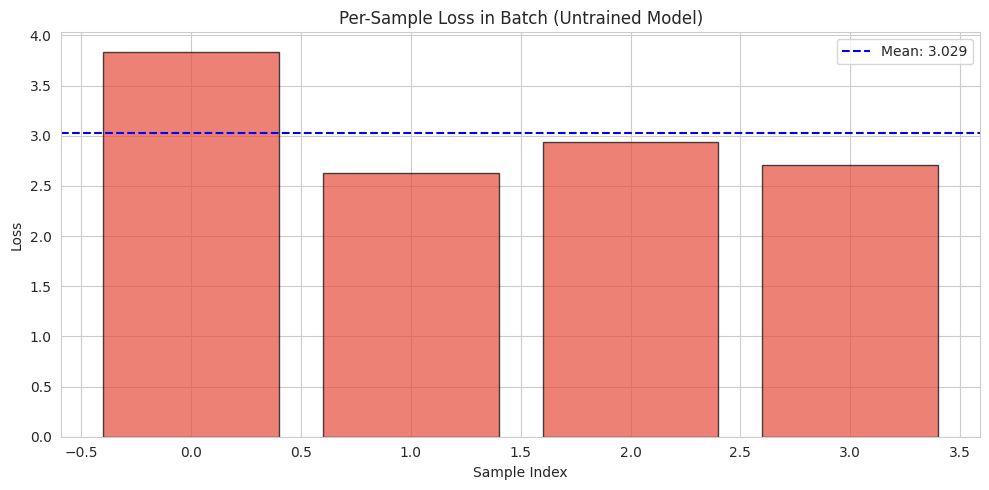


Loss statistics:
  Mean: 3.0294
  Std: 0.4819
  Min: 2.6256
  Max: 3.8396


In [ ]:
# Visualize loss landscape for one batch
print("\n" + "=" * 70)
print("ANALYZING BATCH LOSSES")
print("=" * 70)

# Compute loss for each sample in batch
student.model.eval()
batch_losses = []

with torch.no_grad():
    for i in range(batch['input_ids'].shape[0]):
        sample_output = student(
            input_ids=batch['input_ids'][i:i+1],
            attention_mask=batch['attention_mask'][i:i+1],
            labels=batch['labels'][i:i+1]
        )
        batch_losses.append(sample_output['loss'].item())

# Plot a graph that shows the loss for each sample in the batch
plt.figure(figsize=(10, 5))
plt.bar(range(len(batch_losses)), batch_losses, color='#e74c3c', alpha=0.7, edgecolor='black')
plt.axhline(float(np.mean(batch_losses)), color='blue', linestyle='--', label=f'Mean: {np.mean(batch_losses):.3f}')
plt.xlabel('Sample Index')
plt.ylabel('Loss')
plt.title('Per-Sample Loss in Batch (Untrained Model)')
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nLoss statistics:")
print(f"  Mean: {np.mean(batch_losses):.4f}")
print(f"  Std: {np.std(batch_losses):.4f}")
print(f"  Min: {np.min(batch_losses):.4f}")
print(f"  Max: {np.max(batch_losses):.4f}")

## 5. Test Generation (Inference Mode)

In [ ]:
# Test generation shows how the model makes predictions
# Generation is the inference process: given input, produce output text
print("=" * 70)
print("TESTING GENERATION")
print("=" * 70)

student.model.eval() # Set model to evaluation mode

# Generate predictions from the batch
print("\nGenerating predictions...")
start_time = time.time()

# torch.no_grad() disables gradient computation
with torch.no_grad():
    generated_ids = student.generate(
        input_ids=batch['input_ids'],            # Input: premise + hypothesis
        attention_mask=batch['attention_mask'],  # Mask: which input tokens are real
        max_length=128,                          # Stop after 128 tokens
        num_beams=4                              # Beam search with 4 candidates
    )
    # Beam search process:
    # 1. Start with <start> token
    # 2. At each step, consider top 4 most likely next tokens
    # 3. Keep 4 best sequences (beams) based on cumulative probability
    # 4. Repeat until <end> token or max_length reached
    # 5. Return the highest-scoring complete sequence# Output shape: [batch_size, generated_length]

generation_time = time.time() - start_time

# Time per each token generated
print(f"Time per each sample: {generation_time / batch['input_ids'].shape[0]:.3f}s")

# Time: How long it took to generate the entire batch
print(f"\nGeneration complete in {generation_time:.2f}s")

TESTING GENERATION

Generating predictions...

Generation complete in 1.06s
  Time per sample: 0.264s

Generated IDs shape: torch.Size([4, 8])


In [ ]:
# Decode generated tokens and display predictions
# Then analyze the quality of the predictions by comparing to ground truth
print("\n" + "=" * 70)
print("PREDICTIONS vs GROUND TRUTH")
print("=" * 70)

# Decode generated token IDs to text
# Example: [1820, 19, 59, 8] → "it is not possible to tell"
predictions = student.decode_batch(generated_ids)

# Decode ground truth (target) labels
labels_for_decode = batch['labels'].clone()
labels_for_decode[labels_for_decode == -100] = preprocessor.tokenizer.pad_token_id # Replace -100 with pad token for decoding
ground_truths = student.decode_batch(labels_for_decode) # Decode ground truth explanations

# Decode inputs such as premise + hypothesis
inputs = student.decode_batch(batch['input_ids'])

# Display comparisons for first 3 samples
for i in range(min(3, len(predictions))):
    print(f"\n{'='*70}")
    print(f"SAMPLE {i+1}")
    print(f"{'='*70}")

    # INPUT: The formatted NLI task (premise + hypothesis)

    print(f"\nInput:\n{inputs[i]}")# - Model can generate text

    # WHAT THIS TELLS US:

    # GROUND TRUTH: What the model SHOULD generate (human explanation)    
    print(f"\nGround Truth:\n{ground_truths[i]}")    

    # GROUND TRUTH LENGTH: Length of the human explanation 
    print(f"Ground truth length: {len(ground_truths[i].split())} words")

    # PREDICTION LENGTH: Length of the model's generated explanation
    print(f"\nPrediction length: {len(predictions[i].split())} words")

    # At that point, since the model is untrained, we expect poor quality outputs such as:
    # - yes
    # - no
    # - it is not possible to tell

    # PREDICTION: What the model ACTUALLY generated
    print(f"\nPrediction (untrained):\n{predictions[i]}")    


PREDICTIONS vs GROUND TRUTH

SAMPLE 1

Input:
nli premise: Two women are embracing while holding to go packages. hypothesis: The sisters are hugging goodbye while holding to go packages after just eating lunch.

Ground Truth:
neutral explanation: The to go packages may not be from lunch.

Prediction (untrained):
it is not possible to tell

Prediction length: 6 words
Ground truth length: 11 words

SAMPLE 2

Input:
nli premise: Two women are embracing while holding to go packages. hypothesis: Two woman are holding packages.

Ground Truth:
entailment explanation: Saying the two women are holding packages is a way to paraphrase that the packages they are holding are to go packages.

Prediction (untrained):
yes

Prediction length: 1 words
Ground truth length: 24 words

SAMPLE 3

Input:
nli premise: Two women are embracing while holding to go packages. hypothesis: The men are fighting outside a deli.

Ground Truth:
contradiction explanation: In the first sentence there is an action of affec

## 6. Test Different Generation Strategies

In [ ]:
# Compare different text generation strategies
# Each strategy balances quality, diversity, and speed differently
print("=" * 70)
print("COMPARING GENERATION STRATEGIES")
print("=" * 70)

# Take a single sample for fair comparison
single_input = batch['input_ids'][0:1]
single_mask = batch['attention_mask'][0:1]

# Define 4 common generation strategies
strategies = {
    # GREEDY DECODING:
    # - Always picks the highest probability token at each step
    # - Fast but can produce repetitive/boring text
    # - Deterministic: same input always gives same output
    'Greedy': {'num_beams': 1, 'do_sample': False},
    
    # BEAM SEARCH (k=4):
    # - Keeps track of top 4 most likely sequences
    # - Better quality than greedy, but slower
    # - Still deterministic
    # - Good default for most tasks
    'Beam Search (4)': {'num_beams': 4, 'do_sample': False},
    
    # SAMPLING (Temperature=1.0):
    # - Randomly samples from probability distribution
    # - Temperature=1.0 means use original probabilities
    # - More diverse but can be incoherent
    # - Non-deterministic: different output each time
    'Sampling (T=1.0)': {'num_beams': 1, 'do_sample': True, 'temperature': 1.0, 'top_k': 50},
    
    # SAMPLING (Temperature=0.7):
    # - Lower temperature = more focused/conservative
    # - Sharpens probability distribution (high-prob tokens get higher)
    # - Balances creativity and coherence
    # - top_k=50 means only consider top 50 tokens at each step
    'Sampling (T=0.7)': {'num_beams': 1, 'do_sample': True, 'temperature': 0.7, 'top_k': 50}
}

results = {}

# Test each strategy
with torch.no_grad():
    for name, params in strategies.items():
        start = time.time()
        generated = student.generate(
            input_ids=single_input,
            attention_mask=single_mask,
            max_length=128,
            **params
        )
        elapsed = time.time() - start
        
        decoded = student.decode_batch(generated)[0]
        results[name] = {'text': decoded, 'time': elapsed}

# Display results
print(f"\nInput: {inputs[0]}\n")

for name, result in results.items():
    print(f"\n--- {name} ({result['time']:.3f}s) ---")
    print(result['text'])

COMPARING GENERATION STRATEGIES

Input: nli premise: Two women are embracing while holding to go packages. hypothesis: The sisters are hugging goodbye while holding to go packages after just eating lunch.


--- Greedy (0.140s) ---
it is not possible to tell

--- Beam Search (4) (0.301s) ---
it is not possible to tell

--- Sampling (T=1.0) (0.166s) ---
it is not possible to tell

--- Sampling (T=0.7) (0.126s) ---
it is not possible to tell


## 7. Initialize Teacher (DatasetTeacher)

In [ ]:
# Initialize DatasetTeacher
print("\n" + "=" * 70)
print("INITIALIZING DATASET TEACHER")
print("=" * 70)

teacher = DatasetTeacher()

print("DatasetTeacher initialized!")
print("\nThis teacher uses pre-generated explanations from: e-SNLI: Human-written explanations")

INFO:src.models.teacher:Initialized DatasetTeacher (using pre-generated explanations)



INITIALIZING DATASET TEACHER

DatasetTeacher initialized!

This teacher uses pre-generated explanations from:
  • e-SNLI: Human-written explanations

No additional compute required!


In [19]:
# Extract teacher knowledge from samples
print("\n" + "=" * 70)
print("EXTRACTING TEACHER KNOWLEDGE")
print("=" * 70)

# Get raw samples
sample_indices = [0, 1, 2]

for idx in sample_indices:
    raw_sample = test_data[idx]
    
    # Extract teacher knowledge
    teacher_knowledge = teacher.extract_teacher_knowledge(raw_sample, task_type="nli")
    
    print(f"\n--- Sample {idx + 1} ---")
    print(f"Premise: {raw_sample['premise']}")
    print(f"Hypothesis: {raw_sample['hypothesis']}")
    print(f"\nTeacher Knowledge:")
    print(f"  Label: {teacher_knowledge['label']}")
    print(f"  Explanation: {teacher_knowledge['explanation']}")
    print(f"  Alternative explanations available: {len([e for e in teacher_knowledge['alternative_explanations'] if e])}")


EXTRACTING TEACHER KNOWLEDGE

--- Sample 1 ---
Premise: Two women are embracing while holding to go packages.
Hypothesis: The sisters are hugging goodbye while holding to go packages after just eating lunch.

Teacher Knowledge:
  Label: 1
  Explanation: The to go packages may not be from lunch.
  Alternative explanations available: 2

--- Sample 2 ---
Premise: Two women are embracing while holding to go packages.
Hypothesis: Two woman are holding packages.

Teacher Knowledge:
  Label: 0
  Explanation: Saying the two women are holding packages is a way to paraphrase that the packages they are holding are to go packages.
  Alternative explanations available: 2

--- Sample 3 ---
Premise: Two women are embracing while holding to go packages.
Hypothesis: The men are fighting outside a deli.

Teacher Knowledge:
  Label: 2
  Explanation: In the first sentence there is an action of affection between women while on the second sentence there is a fight between men.
  Alternative explanations av

## 8. Performance Benchmarking

In [ ]:
# Benchmark inference speed
print("=" * 70)
print("INFERENCE SPEED BENCHMARK")
print("=" * 70)

batch_sizes = [1, 4, 8, 16] if device == "cuda" else [1, 4, 8]
inference_times = []

student.model.eval()

for bs in batch_sizes:
    # Create batch
    test_input = batch['input_ids'][:bs].to(device)
    test_mask = batch['attention_mask'][:bs].to(device)
    
    # Warmup
    with torch.no_grad():
        _ = student.generate(test_input, test_mask, max_length=128, num_beams=1)
    
    # Benchmark
    times = []
    for _ in range(5):
        start = time.time()
        with torch.no_grad():
            _ = student.generate(test_input, test_mask, max_length=128, num_beams=1)
        if device == "cuda":
            torch.cuda.synchronize()
        times.append(time.time() - start)
    
    avg_time = np.mean(times)
    throughput = bs / avg_time
    inference_times.append({'batch_size': bs, 'time': avg_time, 'throughput': throughput})
    
    print(f"\nBatch size {bs}:")
    print(f"  Avg time: {avg_time:.3f}s")
    print(f"  Throughput: {throughput:.2f} samples/sec")
    print(f"  Time per sample: {avg_time/bs:.3f}s")

INFERENCE SPEED BENCHMARK

Batch size 1:
  Avg time: 0.121s
  Throughput: 8.28 samples/sec
  Time per sample: 0.121s

Batch size 4:
  Avg time: 0.138s
  Throughput: 28.96 samples/sec
  Time per sample: 0.035s

Batch size 8:
  Avg time: 0.138s
  Throughput: 58.02 samples/sec
  Time per sample: 0.017s

Batch size 16:
  Avg time: 0.132s
  Throughput: 120.86 samples/sec
  Time per sample: 0.008s


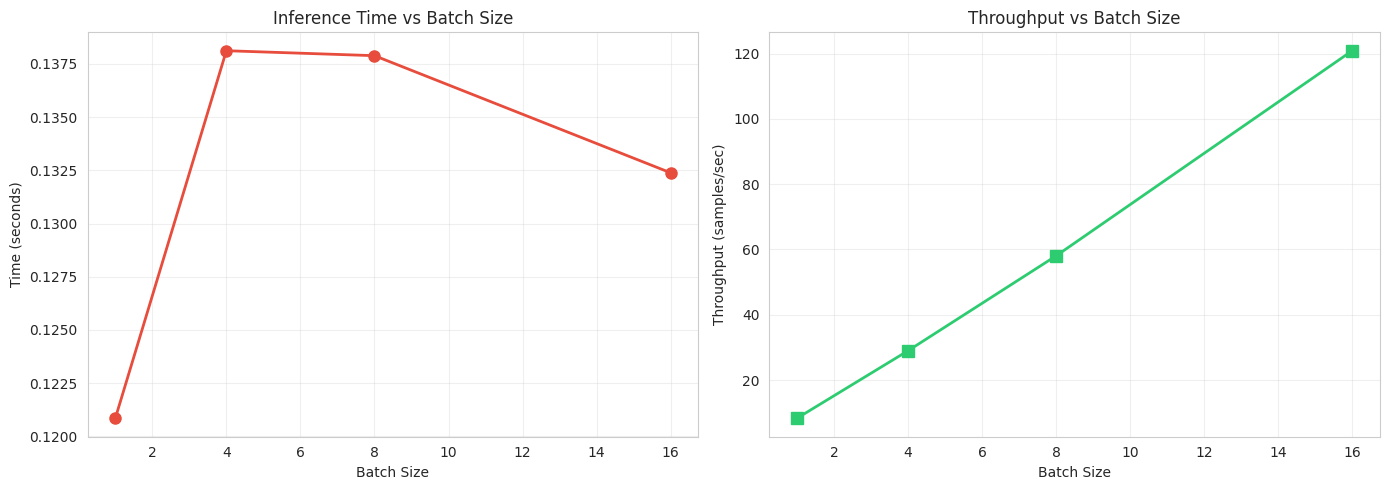


Optimal batch size for throughput: 16


In [ ]:
# Visualize throughput
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

batch_sizes_list = [r['batch_size'] for r in inference_times]
times_list = [r['time'] for r in inference_times]
throughput_list = [r['throughput'] for r in inference_times]

# Plot 1: Time vs Batch Size
ax1.plot(batch_sizes_list, times_list, marker='o', linewidth=2, markersize=8, color='#e74c3c')
ax1.set_xlabel('Batch Size')
ax1.set_ylabel('Time (seconds)')
ax1.set_title('Inference Time vs Batch Size')
ax1.grid(True, alpha=0.3)

# Plot 2: Throughput vs Batch Size
ax2.plot(batch_sizes_list, throughput_list, marker='s', linewidth=2, markersize=8, color='#2ecc71')
ax2.set_xlabel('Batch Size')
ax2.set_ylabel('Throughput (samples/sec)')
ax2.set_title('Throughput vs Batch Size')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Optimal batch size for throughput: {batch_sizes_list[np.argmax(throughput_list)]}")

## 9. Memory Usage Analysis

MEMORY USAGE ANALYSIS

GPU Memory Usage:
  Model parameters: 944.43 MB
  After forward pass: 1084.60 MB
  Peak usage: 3983.05 MB
  Activations: 140.16 MB


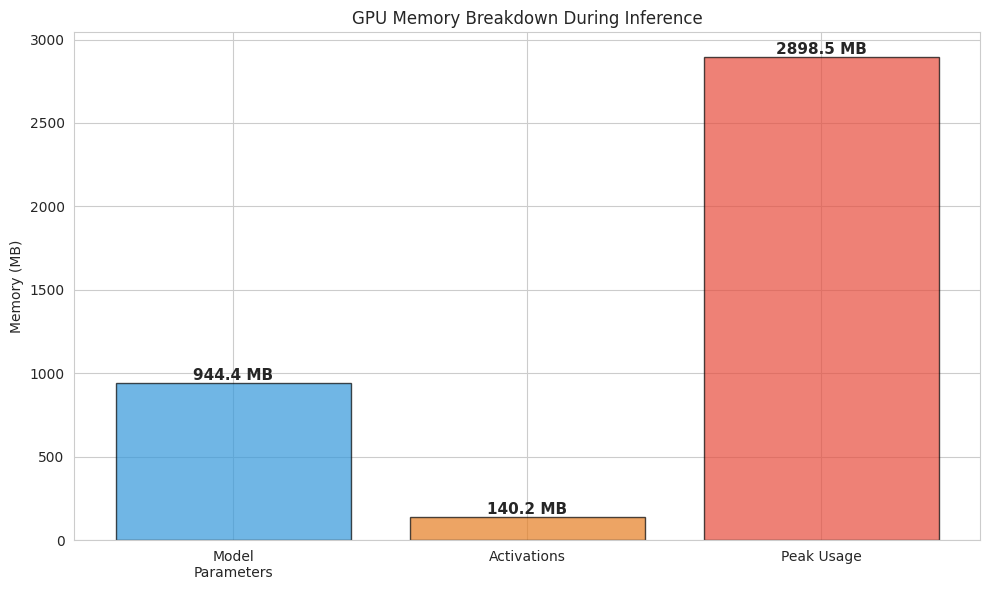

In [22]:
# Analyze memory usage
print("=" * 70)
print("MEMORY USAGE ANALYSIS")
print("=" * 70)

if device == "cuda":
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    
    # Measure memory during forward pass
    initial_memory = torch.cuda.memory_allocated() / 1e6
    
    with torch.no_grad():
        outputs = student(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask'],
            labels=batch['labels']
        )
    
    forward_memory = torch.cuda.memory_allocated() / 1e6
    peak_memory = torch.cuda.max_memory_allocated() / 1e6
    
    print(f"\nGPU Memory Usage:")
    print(f"  Model parameters: {memory['total_mb']:.2f} MB")
    print(f"  After forward pass: {forward_memory:.2f} MB")
    print(f"  Peak usage: {peak_memory:.2f} MB")
    print(f"  Activations: {forward_memory - memory['total_mb']:.2f} MB")
    
    components = ['Model\nParameters', 'Activations', 'Peak Usage']
    sizes = [memory['total_mb'], forward_memory - memory['total_mb'], peak_memory - forward_memory]
    colors = ['#3498db', '#e67e22', '#e74c3c']
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(components, sizes, color=colors, alpha=0.7, edgecolor='black')
    plt.ylabel('Memory (MB)')
    plt.title('GPU Memory Breakdown During Inference')
    
    for bar, size in zip(bars, sizes):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{size:.1f} MB',
                ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("\nCPU mode - GPU memory analysis not available")
    print(f"Model memory footprint: {memory['total_mb']:.2f} MB")

## 10. Compare Different Model Sizes

In [ ]:
# Compare small vs base models
print("=" * 70)
print("COMPARING MODEL SIZES")
print("=" * 70)

# Create small model
print("\nLoading FLAN-T5-small...")
student_small = create_student_model(model_size="small", device=device)

models_comparison = [
    {'name': 'FLAN-T5-small', 'model': student_small},
    {'name': 'FLAN-T5-base', 'model': student}
]

comparison_results = []

for model_dict in models_comparison:
    model_name = model_dict['name']
    model = model_dict['model']
    
    info = model.get_model_info()
    mem = model.get_memory_footprint()
    
    # Measure inference time
    model.model.eval()
    test_input = batch['input_ids'][:4].to(device)
    test_mask = batch['attention_mask'][:4].to(device)
    
    times = []
    for _ in range(3):
        start = time.time()
        with torch.no_grad():
            _ = model.generate(test_input, test_mask, max_length=128, num_beams=1)
        if device == "cuda":
            torch.cuda.synchronize()
        times.append(time.time() - start)
    
    avg_time = np.mean(times)
    
    comparison_results.append({
        'name': model_name,
        'parameters': info['parameters'],
        'memory_mb': mem['total_mb'],
        'inference_time': avg_time,
        'layers': info['encoder_layers']
    })

# Display comparison
print("\n" + "=" * 70)
print(f"{'Model':<20} {'Params':<15} {'Memory (MB)':<15} {'Time (s)':<15} {'Layers':<10}")
print("=" * 70)

for result in comparison_results:
    print(f"{result['name']:<20} {result['parameters']/1e6:<14.1f}M {result['memory_mb']:<15.1f} "
          f"{result['inference_time']:<15.3f} {result['layers']:<10}")

# Calculate speedup
speedup = comparison_results[1]['inference_time'] / comparison_results[0]['inference_time']
compression = comparison_results[1]['parameters'] / comparison_results[0]['parameters']

print("\n" + "=" * 70)
print(f"Small is {speedup:.2f}x faster than base")
print(f"Base has {compression:.2f}x more parameters than small")
print("=" * 70)

In [ ]:
# Visualize model comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

model_names = [r['name'].replace('FLAN-T5-', '') for r in comparison_results]
colors_viz = ['#3498db', '#e74c3c']

# Parameters
params = [r['parameters']/1e6 for r in comparison_results]
axes[0].bar(model_names, params, color=colors_viz, alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Parameters (Millions)')
axes[0].set_title('Model Size')
for i, v in enumerate(params):
    axes[0].text(i, v + 5, f'{v:.1f}M', ha='center', va='bottom', fontweight='bold')

# Memory
memory_vals = [r['memory_mb'] for r in comparison_results]
axes[1].bar(model_names, memory_vals, color=colors_viz, alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Memory (MB)')
axes[1].set_title('Memory Footprint')
for i, v in enumerate(memory_vals):
    axes[1].text(i, v + 10, f'{v:.0f}MB', ha='center', va='bottom', fontweight='bold')

# Inference Time
time_vals = [r['inference_time'] for r in comparison_results]
axes[2].bar(model_names, time_vals, color=colors_viz, alpha=0.7, edgecolor='black')
axes[2].set_ylabel('Inference Time (seconds)')
axes[2].set_title('Inference Speed (batch=4)')
for i, v in enumerate(time_vals):
    axes[2].text(i, v + 0.01, f'{v:.3f}s', ha='center', va='bottom', fontweight='bold')

plt.suptitle('FLAN-T5 Model Comparison', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 11. Summary

In [ ]:
print("\n" + "=" * 70)
print("MODEL TESTING SUMMARY")
print("=" * 70)

print("\nSTUDENT MODEL (FLAN-T5-base):")
print(f"  • Parameters: {model_info['parameters']:,}")
print(f"  • Memory: {memory['total_mb']:.2f} MB")
print(f"  • Inference speed: ~{1/inference_times[0]['time']:.2f} samples/sec (single)")


print("\nPERFORMANCE INSIGHTS:")
print(f"  • FLAN-T5-small is {speedup:.2f}x faster but {compression:.2f}x smaller")
print(f"  • Optimal batch size for throughput: {batch_sizes_list[np.argmax(throughput_list)]}")